In [2]:
import sys
import torch

sys.path.insert(0, "..")
basedir = "../.."

import models

from common.config import create_object, load_config

%matplotlib widget

torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# wconfig = load_config("../autoencoder/configs/experiments/donnormal.yaml")
# experiment = create_object(wconfig)

# wpcaconfig = load_config("../autoencoder/configs/experiments/weldpca.yaml")
# wpcaconfig.windows = 3
# wpcaconfig.aeparams.reduced = 10
# pcaexperiment = create_object(wpcaconfig)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
# load
dconfig = load_config(f"../configs/data/shallow/shallow_rads_FULL.yaml")
dconfig.datasize.spacedim = 2
dset = create_object(dconfig)

In [4]:
dset.data.shape

(1000, 101, 64, 64)

In [ ]:
config = load_config("../configs/experiments/weldnormal.yaml")
experiment2 = models.WeldHelper(config)

weld2 = experiment2.create_weld(dset, k=4, windows=1, td=None, seed=0, accumulateprop=True, device=device)
weld2.train_aes_plus_props(200, lr=1e-3)
weld2.train_propagators(50)
weld2.train_aes(50, lr=1e-4, onlydecoder=True)
#weld2.train_transcoders(200)

Windows: [[0, 100]]
Training 1 WeldNet AEs and props together
Number of NN trainable parameters 828533
Starting training WeldNet AE + Prop 1/1 (0->100) at Wed Sep 10 14:26:44 2025...
train torch.Size([900, 101, 64, 64]) test (100, 101, 64, 64)
1: Train Loss 4.246e-02 + 9.178e-05, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.307728, 0.394713, 0.670447
11: Train Loss 1.648e-03 + 7.204e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.054926, 0.080105, 0.355454
21: Train Loss 9.022e-04 + 8.386e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.038158, 0.059584, 0.317948
31: Train Loss 6.658e-04 + 1.095e-05, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.032427, 0.051737, 0.312158
41: Train Loss 4.805e-04 + 1.305e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.027130, 0.043940, 0.323542
51: Train Loss 4.080e-04 + 1.113e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.024700, 0.040577, 0.314128
61: Train Loss 3.508e-04 + 1.336e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.

KeyboardInterrupt: 

In [20]:
from models import *

class NewTimeInputModel():
  def __init__(self, dataset, ticlass, tiinfo, activation, td=None, seed=0, device=0, residual=0):
    self.dataset = dataset
    self.device = device
    self.td = td
    self.residual = residual
  
    if self.td is None:
      self.prefix = f"{self.dataset.name}{str(ticlass.__name__)}"
    else:
      self.prefix = self.td

    torch.manual_seed(seed)
    np.random.seed(seed)
    self.seed = seed
    self.timetaken = 0

    datacopy = self.dataset.data.copy()
    self.numtrain = int(datacopy.shape[0] * 0.8)
    
    self.T = self.dataset.data.shape[1]
    self.trainarr = datacopy[:self.numtrain]
    self.testarr = datacopy[self.numtrain:]

    self.ticlass = ticlass
    self.optparams = None

    self.datadim = len(self.dataset.data.shape) - 2
    if len(tiinfo) == 1:
      self.model = self.ticlass(tiinfo[0], activation).to(self.device)
    elif len(tiinfo) == 2:
      self.model = self.ticlass(tiinfo[0], tiinfo[1], activation).to(self.device)
    else:
      assert(False)

    #self.tidata = [ticlass, tiinfo]
    #self.datadata = [np.floor(np.sum(self.dataset.data) * 100), self.dataset.data.shape]

    self.metadata = {
      "model_class": ticlass.__name__,
      "tiinfo": tiinfo,
      "activation": activation.__name__ if hasattr(activation, '__name__') else str(activation),
      "dataset_name": dataset.name,
      "data_shape": list(dataset.data.shape),
      "data_checksum": float(np.sum(dataset.data)),
      "seed": seed,
    }

    self.epochs = []

  def get_ti_errors(self, testarr, ords=(2,), times=None, aggregate=True, tstart=0):
    assert(aggregate or len(ords) == 1)
    
    if isinstance(testarr, np.ndarray):
      testarr = torch.tensor(testarr, dtype=torch.float32)

    if times is None:
      times = torch.linspace(0, 1, self.T, dtype=testarr.dtype)[tstart+1:]
  
    out = self.forward(testarr[:, tstart], times)
    
    n = testarr.shape[0]
    orig = testarr[:, tstart+1:].cpu().detach().numpy()
    out = out.cpu().detach().numpy()

    if aggregate:
      orig = orig.reshape([n, -1])
      out = out.reshape([n, -1])
      testerrs = []
      for o in ords:
        testerrs.append(np.mean(np.linalg.norm(orig - out, axis=1, ord=o) / np.linalg.norm(orig, axis=1, ord=o)))

      return tuple(testerrs)
    
    else:
      o = ords[0]
      testerrs = []

      if len(times) == 1:
        t = times[0]
        origslice = orig[:, t-1].reshape([n, -1])
        outslice = out.reshape([n, -1])
        return np.linalg.norm(origslice - outslice, axis=1, ord=o) / np.linalg.norm(origslice, axis=1, ord=o)
      else:
        for t in range(orig.shape[1]):
          origslice = orig[:, t].reshape([n, -1])
          outslice = out[:, t].reshape([n, -1])
          testerrs.append(np.mean(np.linalg.norm(origslice - outslice, axis=1, ord=o) / np.linalg.norm(origslice, axis=1, ord=o)))

        return testerrs

  def forward(self, x, ts):
    if isinstance(self.model, FFNet):
      origshape = list(x.shape[-self.datadim:])

      x = x.reshape(list(x.shape[:-self.datadim]) + [-1])

      T = ts.shape[0]
      x_exp = x.unsqueeze(-2)
      t_exp = ts.reshape(*([1] * (x.dim() - 1)), -1, 1)

      x_brd = x_exp.expand(*x.shape[:-1], T, x.shape[-1])
      t_brd = t_exp.expand(*x.shape[:-1], T, 1)

      xts = torch.cat((x_brd, t_brd), dim=-1)         
  
      out = self.model(xts)


      output = out.reshape(list(out.shape)[:-1] + origshape)

      if self.residual == 2:
        return xts[..., :-1] + t_brd * output
      elif self.residual == 1:
        return xts[..., :-1] + output
      else:
        return output
        
    elif isinstance(self.model, DeepONet):
      B, S = x.shape
      device = x.device

      ts_tensor = torch.as_tensor(ts, device=device)
      spaces = torch.linspace(0, 1, S, device=device)

      s_grid, t_grid = torch.meshgrid(spaces, ts_tensor, indexing='ij')

      inputs = torch.stack((s_grid, t_grid), dim=-1)
      
      out = self.model(x, inputs)
      return out
    
    else:
      assert(False)

  def load_model(self, filename_prefix, verbose=False, min_epochs=0):
    search_path = f"savedmodels/timeinput/{filename_prefix}*.pickle"
    matching_files = glob.glob(search_path)

    print("Searching for model files matching prefix:", filename_prefix)
    if not hasattr(self, "metadata"):
        raise ValueError("Missing self.metadata. Cannot match models without metadata. Ensure model has been initialized with same config.")

    for addr in matching_files:
      try:
          with open(addr, "rb") as handle:
              dic = pickle.load(handle)
      except Exception as e:
          if verbose:
              print(f"Skipping {addr} due to read error: {e}")
          continue

      meta = dic.get("metadata", {})
      is_match = all(
          meta.get(k) == self.metadata.get(k)
          for k in meta.keys()
      )

      # Check if model meets the minimum epoch requirement
      model_epochs = dic["epochs"]
      if model_epochs is None:
          if verbose:
              print(f"Skipping {addr} due to missing epoch metadata.")
          continue
      elif isinstance(model_epochs, list):  # handle legacy or list format
          if sum(model_epochs) < min_epochs:
              if verbose:
                  print(f"Skipping {addr} due to insufficient epochs ({sum(model_epochs)} < {min_epochs})")
              continue
      elif model_epochs < min_epochs:
          if verbose:
              print(f"Skipping {addr} due to insufficient epochs ({model_epochs} < {min_epochs})")
          continue

      if is_match:
          print("Model match found. Loading from:", addr)
          self.model.load_state_dict(dic["model"])
          self.epochs = model_epochs
          self.timetaken = dic["timetaken"]
          if "opt" in dic:     
            self.optparams = dic["opt"]

          return True
      elif verbose:
          print("Metadata mismatch in file:", addr)
          for k in self.metadata:
              print(f"{k}: saved={meta.get(k)} vs current={self.metadata.get(k)}")

    print("Load failed. No matching models found.")
    print("Searched:", matching_files)
    return False

  def train_model(self, epochs, save=True, optim=torch.optim.AdamW, lr=1e-4, printinterval=10, batch=32, ridge=0, loss=None, best=True, verbose=False, numts=1):
    def train_epoch(dataloader, writer=None, optimizer=None, scheduler=None, ep=0, printinterval=10, loss=None, testarr=None):
      losses = []
      testerrors1 = []
      testerrors2 = []
      testerrorsinf = []

      def closure(batch):
        optimizer.zero_grad()
        
        #res = 0
        alltimes = torch.linspace(0, 1, self.T, dtype=batch.dtype)
        #for t in range(self.T):
        
        ts = random.sample(range(self.T), numts)
        res = 0
        for t in ts:
          out = self.forward(batch[:, t], alltimes[t+1:])
          res += loss(batch[:, t+1:], out)
          
        res /= len(ts)
        res.backward()
        
        if writer is not None and self.trainstep % 5 == 0:
          writer.add_scalar("main/loss", res, global_step=self.trainstep)

        return res

      for batch in dataloader:
        self.trainstep += 1
        error = optimizer.step(lambda: closure(batch))
        losses.append(float(error.cpu().detach()))

      if scheduler is not None:
        scheduler.step(np.mean(losses))

      # print test
      if printinterval > 0 and (ep % printinterval == 0):
        testerr1, testerr2, testerrinf = self.get_ti_errors(testarr, ords=(1, 2, np.inf))
        if scheduler is not None:
          print(f"{ep+1}: Train Loss {error:.3e}, LR {scheduler.get_last_lr()[-1]:.3e}, Relative TI Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")
        else:
          print(f"{ep+1}: Train Loss {error:.3e}, Relative TI Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")

        if writer is not None:
            writer.add_scalar("misc/relativeL1error", testerr1, global_step=ep)
            writer.add_scalar("main/relativeL2error", testerr2, global_step=ep)
            writer.add_scalar("misc/relativeLInferror", testerrinf, global_step=ep)

      return losses, testerrors1, testerrors2, testerrorsinf
  
    loss = nn.MSELoss() if loss is None else loss()

    losses, testerrors1, testerrors2, testerrorsinf = [], [], [], []
    self.trainstep = 0

    train = torch.tensor(self.trainarr, dtype=torch.float32).to(self.device)
    test = self.testarr  

    opt = optim(self.model.parameters(), lr=lr, weight_decay=ridge)
    scheduler = lr_scheduler.ReduceLROnPlateau(opt, patience=20, factor=0.3)
    dataloader = DataLoader(train, shuffle=False, batch_size=batch)

    if self.optparams is not None:
      opt.load_state_dict(self.optparams)

    writer = None
    if self.td is not None:
      name = f"./tensorboard/{datetime.datetime.now().strftime('%d-%B-%Y')}/{self.td}/{datetime.datetime.now().strftime('%H.%M.%S')}/"
      writer = torch.utils.tensorboard.SummaryWriter(name)
      print("Tensorboard writer location is " + name)

    print("Number of NN trainable parameters", utils.num_params(self.model))
    print(f"Starting training TI model {self.metadata['model_class']} at {time.asctime()}...")
    print("train", train.shape, "test", test.shape)
      
    start = time.time()
    bestdict = { "loss": float(np.inf), "ep": 0 }
    for ep in range(epochs):
      lossesN, testerrors1N, testerrors2N, testerrorsinfN = train_epoch(dataloader, optimizer=opt, scheduler=scheduler, writer=writer, ep=ep, printinterval=printinterval, loss=loss, testarr=test)
      losses += lossesN; testerrors1 += testerrors1N; testerrors2 += testerrors2N; testerrorsinf += testerrorsinfN

      if best and ep > epochs // 2:
        avgloss = np.mean(lossesN)
        if avgloss < bestdict["loss"]:
          bestdict["model"] = self.model.state_dict()
          bestdict["opt"] = opt.state_dict()
          bestdict["loss"] = avgloss
          bestdict["ep"] = ep
        elif verbose:
          print(f"Loss not improved at epoch {ep} (Ratio: {avgloss/bestdict['loss']:.2f}) from {bestdict['ep']} (Loss: {bestdict['loss']:.2e})")
      
    end = time.time()
    self.timetaken += end - start
    print(f"Finished training TI model {self.metadata['model_class']} at {time.asctime()}...")

    if best:
      self.model.load_state_dict(bestdict["model"])
      opt.load_state_dict(bestdict["opt"])

    self.optparams = opt.state_dict()
    self.epochs.append(epochs)

    if save:
      now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
      readable_shape = "x".join(map(str, self.metadata["tiinfo"]))

      # Compute total training epochs
      total_epochs = sum(self.epochs) if isinstance(self.epochs, list) else self.epochs

      filename = (
          f"{self.dataset.name}_"
          f"{self.ticlass.__name__}_"
          f"{self.metadata['activation']}_"
          f"{readable_shape}_"
          f"{self.seed}_"
          f"{total_epochs}ep_"
          f"{now}.pickle"
      )

      dire = "savedmodels/timeinput"
      addr = os.path.join(dire, filename)

      if not os.path.exists(dire):
          os.makedirs(dire)

      with open(addr, "wb") as handle:
          pickle.dump({
              "model": self.model.state_dict(),
              "metadata": self.metadata,
              "opt": self.optparams,
              "epochs": self.epochs,
              "timetaken": self.timetaken
          }, handle, protocol=pickle.HIGHEST_PROTOCOL)

      print("Model saved at", addr)

    return { "losses": losses, "testerrors1": testerrors1, "testerrors2": testerrors2, "testerrorsinf": testerrorsinf }

class NewTimeInputHelper():
  def __init__(self, config):
    self.update_config(config)

  def update_config(self, config):
    self.config = deepcopy(config)

  def create_timeinput(self, dataset, config=None, **args):
    if config is None:
      config = self.config

    assert(len(dataset.data.shape) < 5)
    if len(dataset.data.shape) == 3:
      din = dataset.data.shape[2]
    else:
      din = dataset.data.shape[2] * dataset.data.shape[3]

    td = args.get("td", None)
    seed = args.get("seed", 0)
    device = args.get("device", 0)
    k = args.get("k", None)

    residual = args.get("residual", 0)

    ticlass = args.get("ticlass", config.ticlass)

    assert(ticlass == "FFNet")
    ticlass = FFNet
    ffseq = deepcopy(args.get("ffseq", config.ffseq))

    ffseq[0] = din + 1
    ffseq[-1] = din

    tiinfo = (ffseq,)

    activation = get_activation(args.get("activation", config.activation))

    return NewTimeInputModel(dataset, ticlass, tiinfo, activation, td=td, seed=seed, device=device, residual=residual)

  @staticmethod
  def get_operrs(ti, times=None, testonly=True):
    if isinstance(ti, NewTimeInputModel):
      if testonly:
        data = ti.testarr
      else:
        data = np.concatenate((ti.trainarr, ti.testarr), axis=0)

      errors = ti.get_ti_errors(data, times=times, aggregate=False)
    elif isinstance(ti, WeldNet):
      errors = WeldHelper.get_operrs(ti, testonly=testonly)
    elif isinstance(ti, HighDimProp):
      errors = HighDimPropHelper.get_operrs(ti, testonly=testonly)
    elif isinstance(ti, ELDNet):
      errors = ELDHelper.get_operrs(ti, testonly=testonly)
      
    return errors
  
  @staticmethod
  def plot_op_predicts(ti: NewTimeInputModel, testonly=True, xs=None, cmap="viridis"):
    if testonly:
      data = ti.trainarr
    else:
      data = np.concatenate((ti.trainarr, ti.testarr), axis=0)

    if xs is None:
        xs = np.linspace(0, 1, data.shape[2])

    data = torch.tensor(np.float32(data)).to(ti.device)

    times = torch.arange(1, ti.T)
    tt = times.to(ti.device) / ti.T
    predicts = ti.forward(data[:, 0], tt)
    
    predicts = predicts.cpu().detach()
    data = data.cpu().detach()

    errors = []
    n = predicts.shape[0]
    for s in times:
      currpredict = predicts[:, s-1].reshape((n, -1))
      currreference = data[:, s].reshape((n, -1))
      errors.append(np.mean(np.linalg.norm(currpredict - currreference, axis=1) / np.linalg.norm(currreference, axis=1)))
        
    print(f"Average Relative L2 Error over all times: {np.mean(errors):.4f}")

    if len(data.shape) == 3:
      fig, ax = plt.subplots(figsize=(4, 3))
    elif len(data.shape) == 4:
      fig, axes = plt.subplots(1, 4, figsize=(12, 3))
      fig.subplots_adjust(right=0.90)
      sub_ax = plt.axes([0.91, 0.15, 0.02, 0.65])

    @widgets.interact(i=(0, n-1), s=(1, ti.T-1))
    def plot_interact(i=0, s=1):
      print(f"Avg Relative L2 Error for t0 to t{s}: {errors[s-1]:.4f}")

      if len(data.shape) == 3:
        ax.clear()
        ax.set_title(f"RelL2 {np.linalg.norm(predicts[i, s-1] - data[i, s]) / np.linalg.norm(data[i, s])}")
        ax.plot(xs, data[i, 0], label="Input", linewidth=1)
        ax.plot(xs, predicts[i, s-1], label="Predicted", linewidth=1)
        ax.plot(xs, data[i, s], label="Exact", linewidth=1)
        ax.legend()
      elif len(data.shape) == 4:
        for axx in axes:
          axx.clear()

        axes[0].imshow(data[i, 0], cmap=cmap)
        axes[0].set_title("Initial")
        axes[1].imshow(data[i, s], cmap=cmap)
        axes[1].set_title("Exact")
        axes[2].imshow(predicts[i, s-1], cmap=cmap)
        axes[2].set_title("Predicted")

        cb = axes[3].imshow(np.abs(predicts[i, s-1] - data[i, s]), cmap=cmap)
        axes[3].set_title("|Difference|")
        fig.colorbar(cb, cax=sub_ax)

  @staticmethod
  def compare_operrs(models, labels=None):
    fig, ax = plt.subplots()

    if labels is None:
      labels = range(len(models))

    for lbl, x in zip(labels, models):
      operrs = TimeInputHelper.get_operrs(x, testonly=True)
      ax.plot(np.log10(operrs), label=lbl)

    ax.legend()
    #ax.set_title("Operator Error for Various #Windows")
    ax.set_ylabel("$log_{10}$(Operator Error)")
    ax.set_xlabel("Time")

    fig.tight_layout()
    return fig

  @staticmethod
  def plot_errorparams(ti, param=-1):
    if param == -1:
        # Auto-detect one varying parameter
        param = 0
        P = ti.dataset.params.shape[1]
        for p in range(P):
            if np.abs(ti.dataset.params[0, p] - ti.dataset.params[1, p]) > 0:
                param = p
                break

    l2error = np.asarray(TimeInputHelper.get_operrs(ti, times=[ti.T - 1]))
    params = ti.dataset.params

    print(params.shape, l2error.shape)

    if isinstance(param, (list, tuple, np.ndarray)) and len(param) == 2:
        # 3D scatter plot for 2 varying parameters
        x = params[:, param[0]]
        y = params[:, param[1]]
        z = l2error

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=10)

        ax.set_xlabel(f"Param {param[0]}")
        ax.set_ylabel(f"Param {param[1]}")
        ax.set_zlabel("Operator Error")
        fig.colorbar(sc, ax=ax, label="Operator Error")

    else:
        # Fallback to 2D scatter if param is 1D
        fig, ax = plt.subplots()
        ax.scatter(params[:, param], l2error, s=2)
        ax.set_xlabel(f"Parameter {param}")
        ax.set_ylabel("Operator Error")

    fig.tight_layout()

  @staticmethod
  def compare_errorparams(tis, labels=None, param=-1):
    if param == -1:
      param = 0
      P = tis[0].dataset.params.shape[1]

      for p in range(P):
        if np.abs(tis[0].dataset.params[0, p] - tis[0].dataset.params[1, p]) > 0:
          param = p
          break
      
    if labels is None:
      labels = [utils.num_params(x.model) for x in tis]

    fig, ax = plt.subplots()
    for lbl, ti in zip(labels, tis):
      l2error = np.asarray(TimeInputHelper.get_operrs(ti, times=[ti.T-1], testonly=False))
      print(l2error.shape, ti.dataset.params[:, param].shape)
      ax.scatter(ti.dataset.params[:, param], l2error, label=lbl, s=2)
  
    ax.set_title(f"Error vs. Parameter {param}")
    ax.set_xlabel("Parameter Value")
    ax.set_ylabel("Operator Error")
    ax.legend()

    fig.tight_layout()
    return fig


In [22]:
from copy import deepcopy
import random

config = load_config("../configs/experiments/ffnetnormal.yaml")
experiment = NewTimeInputHelper(config)

test = experiment.create_timeinput(dset, td=None, seed=0, device=device)
  
test.train_model(200, lr=1e-3)

Number of NN trainable parameters 23936784
Starting training TI model FFNet at Wed Sep 10 13:52:11 2025...
train torch.Size([64, 101, 128, 128]) test (17, 101, 128, 128)
1: Train Loss 3.463e-01, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.812760, 0.860883, 1.378704
11: Train Loss 3.237e-03, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.098992, 0.152095, 0.783342
21: Train Loss 1.366e-03, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.075049, 0.131750, 0.672710
31: Train Loss 1.414e-03, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.061124, 0.128862, 0.702262
41: Train Loss 1.985e-03, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.082877, 0.140175, 0.727257
51: Train Loss 4.537e-03, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.215341, 0.247406, 0.756694
61: Train Loss 2.884e-03, LR 3.000e-04, Relative TI Error (1, 2, inf): 0.071028, 0.129149, 0.661394
71: Train Loss 2.238e-03, LR 3.000e-04, Relative TI Error (1, 2, inf): 0.059257, 0.122764, 0.652981
81: Train Loss 8.850e-04, LR 9.

KeyboardInterrupt: 

In [26]:
WeldHelper.get_operrs(weld2)[-1]

0.059707817

In [27]:
NewTimeInputHelper.get_operrs(test)[-1]

0.071718276

Loading the file here

In [5]:
import h5py
import numpy as np

# Open an HDF5 file
file_path = "../../../../Downloads/2D_rdb_NA_NA.h5"

f = h5py.File(file_path, "r")

print("Keys in the file:", list(f.keys()))

# Access a dataset by name (replace 'dataset_name' with actual key)
#dataset = f["dataset_name"][:]

# # Convert to NumPy array
# np_array = np.array(dataset)
# print("Shape of array:", np_array.shape)
# print("Data type:", np_array.dtype)

# If there are multiple datasets, you can iterate over them:
data_dict = {key: f[key] for key in f.keys()}
print("All datasets loaded into dictionary of NumPy arrays.")


Keys in the file: ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122

In [6]:
xs = np.asarray(data_dict["0000"]["grid"]["x"])
ys = np.asarray(data_dict["0000"]["grid"]["y"])
ts = np.asarray(data_dict["0000"]["grid"]["t"])

outputs = []
for key in data_dict.keys():
  outputs.append(np.asarray(data_dict[key]["data"]).squeeze())

outputs = np.stack(outputs, axis=0)
print(outputs.shape)

(1000, 101, 128, 128)


In [30]:
reduced = outputs.reshape((outputs.shape[0], outputs.shape[1], -1))
reduced = np.linalg.norm(reduced, axis=2, ord=1)

_, idunique = np.unique(reduced, return_index=True, axis=0)
outputs_reduced = outputs[idunique]

In [3]:
def radius_from_area(outputs, unit_per_pixel=1.0):
    """
    outputs: (N, N) binary array (1 inside circle, 0 outside), centered.
    unit_per_pixel: how many 'units' each pixel represents along x/y.
    Returns radius in 'units'.
    """
    A_pixels = np.count_nonzero(outputs - 1)          # number of '1' pixels
    r_pixels = np.sqrt(A_pixels / np.pi)          # radius in pixel units
    return r_pixels * unit_per_pixel

def radius_from_dist(outputs, unit_per_pixel=1.0):
    """
    Alternative using farthest '1' pixel distance from center.
    Slightly noisier on small grids but useful as a cross-check.
    """
    N = outputs.shape[0]
    cy = (N - 1) / 2.0
    cx = (N - 1) / 2.0

    ys, xs = np.nonzero(outputs - 1)
    d_pixels = np.hypot(ys - cy, xs - cx)
    # Optional half-pixel boundary correction; comment out if you prefer raw
    r_pixels = d_pixels.max() + 0.5
    return r_pixels * unit_per_pixel

units = (xs[-1] - xs[0]) / len(xs)
rads = []
for i in range(len(outputs)):
  rad = radius_from_dist(outputs[i, 0], unit_per_pixel=units)
  rads.append(rad)

rads_reduced = []
for i in range(len(outputs_reduced)):
  rad = radius_from_dist(outputs_reduced[i, 0], unit_per_pixel=units)
  rads_reduced.append(rad)

print(len(rads), len(rads_reduced))

NameError: name 'xs' is not defined

In [ ]:
print(np.min(rads), np.max(rads), np.mean(rads), np.std(rads))

interactive(children=(IntSlider(value=0, description='i', max=80), IntSlider(value=0, description='t'), Output…

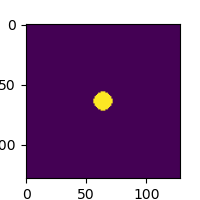

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

In [6]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

fig, ax = plt.subplots(figsize=(2, 2))

@widgets.interact(i=(0, outputs_reduced.shape[0]-1), t=(0, outputs_reduced.shape[1]-1))
def plot_time(i=0, t=0):
  ax.clear()

  print(rads_reduced[i])
  ax.imshow(outputs_reduced[i, t])
  print("min", np.min(outputs_reduced[i, t]), "max", np.max(outputs_reduced[i, t]))

In [8]:
import scipy.io

scipy.io.savemat("shallow_rads.mat", {'alldata': outputs_reduced, 'params': np.asarray(rads_reduced).reshape((len(rads_reduced), 1))})

In [40]:
import numpy as np
import skdim.id

def print_ID(dset, method=skdim.id.MLE, nt=5):
  estimator = method()

  T = dset.shape[1]
  for t in range(0, T, T//nt):
    print(t, estimator.fit(dset[:, t]).dimension_)

  test = dset.reshape([-1, dset.shape[-1]]).copy()
  np.random.shuffle(test)

  maxnum = 10000
  print("together", estimator.fit(test[:maxnum]).dimension_)

dset = outputs_reduced.reshape(list(outputs_reduced.shape[:2]) + [-1])
print_ID(dset, method=skdim.id.MOM)

0 1.6988378359784742
20 1.1689707910260632
40 1.1266458995204423
60 1.2758875552350024
80 1.2473344441970329
100 1.2021479283065724
together 2.262290921178092


In [62]:
rads = np.asarray(rads)

diffs = np.abs(rads[:, None] - rads)
np.fill_diagonal(diffs, np.inf)

diffs

array([[       inf, 1.43206066, 1.18161182, ..., 1.18161182, 4.10719688,
        2.60491833],
       [1.43206066,        inf, 0.25044885, ..., 0.25044885, 5.53925754,
        4.03697899],
       [1.18161182, 0.25044885,        inf, ..., 0.        , 5.28880869,
        3.78653015],
       ...,
       [1.18161182, 0.25044885, 0.        , ...,        inf, 5.28880869,
        3.78653015],
       [4.10719688, 5.53925754, 5.28880869, ..., 5.28880869,        inf,
        1.50227855],
       [2.60491833, 4.03697899, 3.78653015, ..., 3.78653015, 1.50227855,
               inf]])

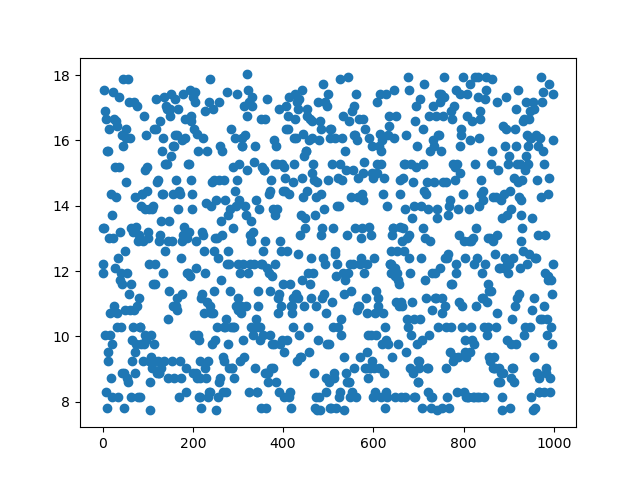

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

In [52]:
fig, ax = plt.subplots()

ax.scatter(range(len(rads)), rads)